# Air Pollution Forecasting - Temp

In [1]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv("../data/data_imputed_2.csv")

In [7]:
data = df[['temp']]

In [17]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [19]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [20]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [40]:
# converting the dataset as supervised learning
reframed = series_to_supervised(scaled, 168, 1)
print(reframed.shape)

(19538, 169)


In [41]:
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = int(365 * 24 * 1.5)

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13140, 1, 168) (13140,) (6398, 1, 168) (6398,)


In [56]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Conv2D, ConvLSTM1D, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential

In [68]:
model = Sequential()
model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(64))
# model.add(Dense(1))
# model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(256))
# model.add(Dense(64))
# model.add(Dropout(0.25))
# model.add(BatchNormalization())
# model.add(Dense(1))
model.add(LSTM(100, activation='relu', return_sequences=True))
# model.add(RepeatVector(1))
model.add(LSTM(100, activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 1, 100)              │         107,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 188,101 (734.77 KB)

 Trainable params: 188,101 (734.77 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
history = model.fit(train_X, train_y, epochs=50, batch_size=264, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/50
40/40 - 3s - 85ms/step - loss: 0.0453 - val_loss: 0.0397
Epoch 2/50
40/40 - 0s - 9ms/step - loss: 0.0129 - val_loss: 0.0363
Epoch 3/50
40/40 - 0s - 9ms/step - loss: 0.0078 - val_loss: 0.0211
Epoch 4/50
40/40 - 0s - 9ms/step - loss: 0.0057 - val_loss: 0.0138
Epoch 5/50
40/40 - 0s - 8ms/step - loss: 0.0049 - val_loss: 0.0080
Epoch 6/50
40/40 - 0s - 9ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 7/50
40/40 - 0s - 9ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 8/50
40/40 - 0s - 9ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 9/50
40/40 - 0s - 9ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 10/50
40/40 - 0s - 11ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 11/50
40/40 - 0s - 9ms/step - loss: 0.0032 - val_loss: 0.0052
Epoch 12/50
40/40 - 0s - 8ms/step - loss: 0.0031 - val_loss: 0.0054
Epoch 13/50
40/40 - 0s - 10ms/step - loss: 0.0030 - val_loss: 0.0053
Epoch 14/50
40/40 - 0s - 8ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 15/50
40/40 - 0s - 9ms/step - loss: 0.0028 - val

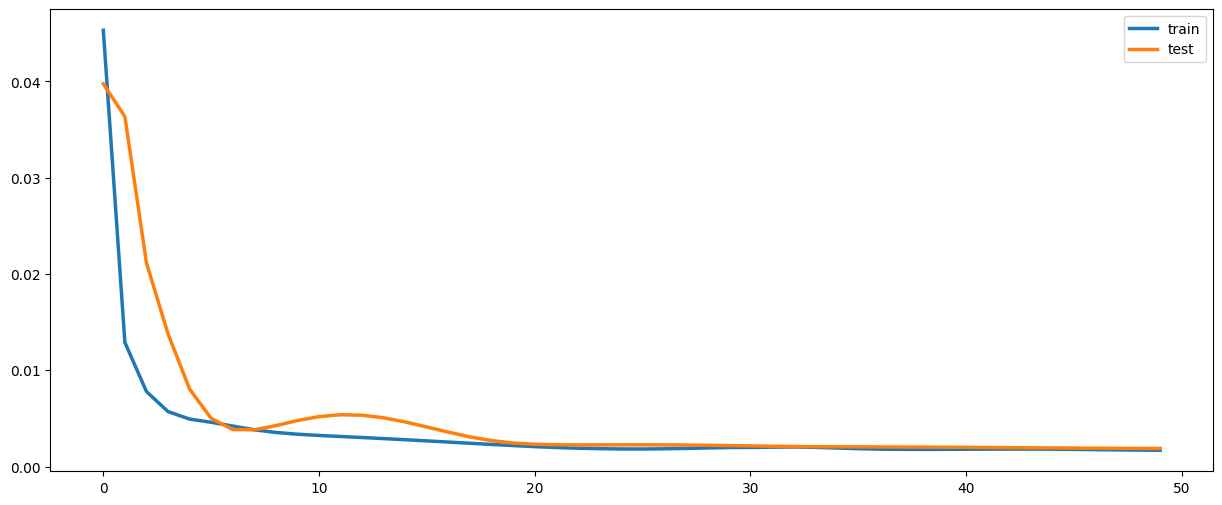

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [71]:
testPredict = model.predict(test_X)
print(testPredict.shape)
testPredict = testPredict.ravel()

print(testPredict.shape)

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(6398, 1)
(6398,)


In [72]:
y_test_true = test[:,1]

In [73]:
poll = np.array(df["aqi"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop

In [75]:
rmse = np.sqrt(mean_squared_error(test_y, testPredict))
print("Test RMSE ="  ,rmse)

Test RMSE = 181.21182
